In [41]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.datasets import cifar10, mnist
import matplotlib.pyplot as plt

In [3]:
plt.style.use('dark_background')

In [4]:
# 1. Set seed
tf.random.set_seed(1)

In [5]:
# 2. Layers
input = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, 3, activation='relu')(input) # get previous layer ↑
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(10, activation='softmax')(x)

In [6]:
model = keras.Model(inputs=input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1568)              0     

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [9]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [10]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [11]:
model.fit(x_train, y_train, batch_size=64, epochs=20, validation_split=0.2)

Epoch 1/20
625/625 [==============================] - 36s 56ms/step - loss: 1.6014 - accuracy: 0.4175 - val_loss: 1.3303 - val_accuracy: 0.5287
Epoch 2/20
625/625 [==============================] - 31s 49ms/step - loss: 1.2753 - accuracy: 0.5450 - val_loss: 1.1192 - val_accuracy: 0.6134
Epoch 3/20
625/625 [==============================] - 28s 45ms/step - loss: 1.1354 - accuracy: 0.5983 - val_loss: 1.1037 - val_accuracy: 0.6158
Epoch 4/20
625/625 [==============================] - 26s 42ms/step - loss: 1.0395 - accuracy: 0.6338 - val_loss: 0.9837 - val_accuracy: 0.6599
Epoch 5/20
625/625 [==============================] - 27s 43ms/step - loss: 0.9699 - accuracy: 0.6593 - val_loss: 0.9615 - val_accuracy: 0.6750
Epoch 6/20
625/625 [==============================] - 27s 43ms/step - loss: 0.9226 - accuracy: 0.6754 - val_loss: 0.9035 - val_accuracy: 0.6908
Epoch 7/20
625/625 [==============================] - 29s 47ms/step - loss: 0.8743 - accuracy: 0.6931 - val_loss: 0.8886 - val_accuracy:

In [15]:
print(model.evaluate(x_test, y_test))

313/313 [==============================] - 2s 5ms/step - loss: 0.8948 - accuracy: 0.7140
[0.8947611451148987, 0.7139999866485596]


In [16]:
# On level tensorflow

In [29]:
class TfConv2D(tf.Module):
    def __init__(self, kernel=(3, 3), channels=1, strides=(2, 2), padding='SAME', activate='relu'):
        super().__init__()
        self.kernel = kernel
        self.channels = channels
        self.strides = strides
        self.padding = padding
        self.activate = activate
        self.fl_init = False

    def __call__(self, x):
        if not self.fl_init:
            # [kernel_x, kernel_y, input_channels, output_channels]
            self.w = tf.random.truncated_normal((*self.kernel, x.shape[-1], self.channels), stddev=0.1, dtype=tf.double)
            self.b = tf.zeros([self.channels], dtype=tf.double)

            self.w = tf.Variable(self.w)
            self.b = tf.Variable(self.b)

            self.fl_init = True

        y = tf.nn.conv2d(x, self.w, strides=(1, *self.strides, 1), padding=self.padding) + self.b

        if self.activate == 'relu':
            return tf.nn.relu(y)
        elif self.activate == 'softmax':
            return tf.nn.softmax(y)

        return y

In [30]:
layer1 = TfConv2D((3, 3), 32)
y = layer1(tf.expand_dims(x_test[0], axis=0))
print(y.shape)

(1, 16, 16, 32)


In [31]:
y = tf.nn.max_pool2d(y, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='SAME')
print(y.shape)

(1, 8, 8, 32)


In [32]:
# encoder

In [33]:
enc_input = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation='relu')(enc_input)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Flatten()(x)
enc_output = layers.Dense(8, activation='linear')(x)

In [34]:
encoder = keras.Model(enc_input, enc_output, name='encoder')

In [35]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255
y_train = y_train / 255

In [37]:
dec_input = layers.Input(shape=(8,), name='encoder_img')
x = layers.Dense(7 * 7 * 8, activation='relu')(dec_input)
x = keras.layers.Reshape((7, 7, 8))(x)
x = layers.Conv2DTranspose(64, 5, strides=(2, 2), activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 5, strides=(2, 2), activation='linear', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
dec_output = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

In [38]:
decoder = keras.Model(dec_input, dec_output, name='decoder')

In [39]:
autoencoder_input = keras.Input(shape=(28, 28, 1), name='img')
x = encoder(autoencoder_input)
autoencoder_output = decoder(x)

In [40]:
autoencoder = keras.Model(autoencoder_input, autoencoder_output, name='autoencoder')

In [42]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [43]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [45]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(x_train, x_train, batch_size=32, epochs=1)

1875/1875 [==============================] - 73s 38ms/step - loss: 0.0306


In [46]:
h = encoder.predict(tf.expand_dims(x_test[0], axis=0))
img = decoder.predict(h)

1/1 [==============================] - 0s 98ms/step


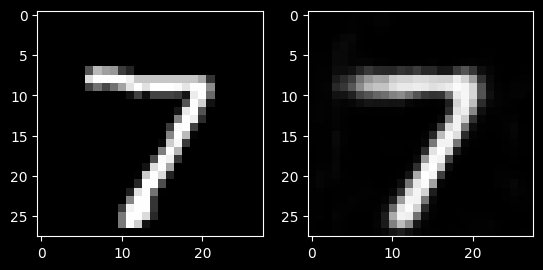

In [48]:
plt.subplot(121)
plt.imshow(x_test[0], cmap='gray')
plt.subplot(122)
plt.imshow(img.squeeze(), cmap='gray')
plt.show()